<code>calculate_RMSE_MAE_S2S_models_all_days.ipynb</code>.  This notebook calculates the RMSE, MAE, and raw error for each S2S model's actual SIE forecasts and anomalous SIE forecasts.  See <code>Calculate_RMSE_MAE_S2S_model_all_seas_COMMON_PERIOD.ipynb</code> for a nicer example. 

<b>inputs:</b><br>
<li>  model name (ecmwf,ukmo,ncep,metreofr) </li>
<li>  seas_str [string for season; ALL if we want to do full year]</li>
<li>  seas_sel [months of season; empty if we want to do full year] </li>
<li>  vrile_thresh [threshhold at which VRILE is estimated </li>
<li>  thresh_str [string for VRILE threshhold] </li>


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from S2S_sea_ice_preprocess import load_model, create_aggregate_regions, create_model_climatology
from S2S_sea_ice_preprocess import create_obs_climatology 
from S2S_sea_ice_VRILEs import get_VRILE_days
from S2S_sea_ice_errors import calculate_errors

## Overview

<li>1) Load model netCDF files, combine with CTRL, and use common reforecast period. <br>
if NCEP, use entire period </li>
<li> 2) Add aggregate regions </li>
<li> 3) Create climatology--model: calculate date of year for valid date, lead time in weeks.<br>
<li> 4) Create observed climatology (static, using only common reforecast period) </li>
<li> 5) Calculate VRILEs in observations.  We define VRILEs based on the lowest <i>p</i>-th percentile of raw sea ice extent, and the lowest <i>p</i>-th percentile of anomalous sea ice extent </li>
    <li> 6) Calculate errors in predicting sea ice following VRILEs: as a function of region, valid date, and lead time. We output raw error (to calculate model bias), mean absolute error (MAE), and root mean squared error (RMSE).  We use both VRILE definitions (based on actual and anomalous SIE) and come up with 2 different sets of errors.

### 1 Load S2S model data

Use <code>load_model</code> to load sea ice extent (SIE) output from the S2S model archive available on SIPN.  The SIE has been calculated from SIC data that was regridded to the SIPN grid following Wayand et al. (2019).  We load all ensemble members for each model, truncate the model reforecasts to the common reforecast period* (1/1/1999-12/31/2014), and take an ensemble-mean of each hindcast.

*For the <code>ncep</code> model, the model reforecasts end in 2011, so we use the entire period for <code>ncep</code> (1/1/1999-12/31/2011).

### 2 Create aggregate regions

The S2S model output available on SIPN is organized into the NSIDC MASIE regions (see them at: https://nsidc.org/data/masie/browse_regions).  To simplify our analysis, we combine a few adjacent MASIE regions that exhibit similar behavior.  We're going to combine the following with <code>create_aggregate_regions</code>:
  * Kara and Laptev Seas (region_KL)
  * Barents, Kara and Laptev Seas (region_BKL)
  * East Siberian, Beaufort, and Chukchi Seas (region_EBC)
  * Atlantic (Baffin Bay and East Greenland Sea) (region_ATL)
  * East Siberian, Beaufort, Chukchi, Laptev Seas (region_EBCL)

### 3 Create climatology for S2S output
For each S2S model output, we create a lead-dependent climatology of sea ice extent (the climatology, of course, will also depend on region).  For each region of each S2S model, we create a lead-dependent climatology by simply averaging sea ice extent for each combination of lead time ($L$) and day of year ($doy$), 

$$ SIE_{clim}(L,doy) = \frac{\sum_{y=1999}^{2014}(SIE (L,doy,y))}{N_{yrs}}$$

This approach is commonly used in S2S forecasting and is based on the description in Sun et al. (2018): https://journals.ametsoc.org/mwr/article/146/5/1601/104172/Subseasonal-Forecasting-with-an-Icosahedral
(see Section 2, paragraphs 2-3 in particular).  Note that we could also bin our forecasts different over lead time--for example, we could bin the forecast by lead week (so SIEs for a given $doy$ at lead days between 0 and 6 days would all be averaged together).  

So, each lead time will have its own climatological cycle of sea ice extent.  Here, we also calculate our forecasts of anomalous SIE ($SIE_{anom}$) based 

### 6 Calculate the RMSE and the MAE.  
In English--for each region ($R$) and lead time ($L$), we calculate both the root mean squared error (RMSE) and the mean absolute error (MAE), <br>

$$RMSE_{R,L} = \sqrt{ \sum_{V} \frac{\left(SIE^{pred}_{R,L} - SIE^{obs}_{R,L}\right)^2}{N_V}}$$ 

$$MAE_{R,L} =  \sum_{V} \frac{abs\left(SIE^{pred}_{R,L} - SIE^{obs}_{R,L}\right)}{N_V}$$ 

We also calculate the raw error ($SIE^{pred}_{R,L} - SIE^{obs}_{R,L}$) so that we can look at the biases in the S2S models

Calculate raw error, mean absolute error, and RMSE.  These calculations will be a function of region and lead time.  See nice notebook for equations for RMSE and MAE

In [2]:
model_name = 'ncep'
seas_str = 'JJA'
seas_sel = [6,7,8]
obs_name = 'NSIDC_0051'
WEEKLY = True
lead_weeks = True
vrile_thresh = 0.05
thresh_str = '05'
nday_change = 5 #number of days for VRILE calculation

Load model output for our desired model

In [3]:
SIE = load_model(model_name)
print('loaded ',model_name)

<xarray.Dataset>
Dimensions:       (ensemble: 3, fore_time: 43, init_time: 4523, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * fore_time     (fore_time) timedelta64[ns] 1 days 2 days ... 42 days 43 days
  * ensemble      (ensemble) int32 0 1 2
  * init_time     (init_time) datetime64[ns] 1999-01-01 ... 2010-12-31
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(3, 16, 43, 15), meta=np.ndarray>
loaded  ncep


Create aggregate regions that combine some of the NSIDC-MASIE regions

In [4]:
SIE = create_aggregate_regions(SIE)
print('combined regions')

combined regions


Now, take the ensemble mean and get lead time in days.  We'll use the first <code>train_frac</code> ensemble members to train the data, and the last (1 - <code>train_frac</code>) members for our test set.

In [5]:
train_frac = 0.75
no_ens = len(SIE.ensemble)
print('we have ',no_ens,' ensemble members; we will use ',np.floor(train_frac*no_ens),' in our training data set')
SIE_test = SIE.sel(ensemble=np.arange(np.floor(train_frac*no_ens),no_ens))
SIE = SIE.sel(ensemble=np.arange(0,np.floor(train_frac*no_ens)))
SIE

we have  4  ensemble members; we will use  3.0  in our training data set


<xarray.DataArray 'Extent' (ensemble: 3, init_time: 4380, fore_time: 43, nregions: 20)>
dask.array<getitem, shape=(3, 4380, 43, 20), dtype=float64, chunksize=(3, 16, 43, 15), chunktype=numpy.ndarray>
Coordinates:
  * init_time     (init_time) datetime64[ns] 1999-01-01 ... 2010-12-31
  * fore_time     (fore_time) timedelta64[ns] 1 days 2 days ... 42 days 43 days
  * ensemble      (ensemble) int64 0 1 2
    region_names  (nregions) object 'panArctic' ... 'East Siberian-Beaufort-Chukchi-Laptev Sea'
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 ... 13 14 15 20 21 22 23 24

In [6]:
SIE_ens_mean = SIE.mean(dim='ensemble')
regions = SIE.region_names
lead_days = SIE.fore_time.dt.days

Convert to dataframe because I like Pandas

In [7]:
SIE_df = SIE_ens_mean.to_dataframe().reset_index()

Calculate the date for forecasts by adding the <code>fore_time</code> to <code>init_time</code>. Rename some columns to make life easier

In [8]:
SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
SIE_df = SIE_df.rename(columns={'region_names':'region',
                           'fore_time':'lead time (days)',
                           'init_time':'init date',
                           'Extent':'SIE'})

Create climatology for model output.  Decide how long we want weeks to be for weekly climatology (default is 7 days)

In [9]:
week_length = 7
nyears = 10
SIE_df = create_model_climatology(SIE_df,7)
print('model climatology created')

model climatology created


Load observations.  NSIDC_0079 is NASA Bootstrap, NSIDC_0051 is NASA team

In [10]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11261)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-10-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Add aggregate regions to obs, convert obs to Pandas dataframe, and trim obs to common reforecast period

In [11]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
common_yrs = np.arange(1999,2015)
obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(common_yrs)]

Calculate our observed climatology 

In [12]:
obs_SIE = create_obs_climatology(obs_SIE)
print('observed climatology created')

observed climatology created


In [13]:
seas_sel
#obs_SIE_x = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.month.isin(seas_sel)]
#obs_SIE_x['poo'] = obs_SIE_x.groupby(['region'])['d_SIE anom'].transform(lambda x: x.quantile(0.05))
#obs_SIE_x

[6, 7, 8]

Estimate observed VRILE days

In [14]:
obs_SIE_VRILE_onlyx, obs_SIE_anom_VRILE_onlyx, obs_SIE_NO_VRILEx, obs_SIE_anom_NO_VRILEx = get_VRILE_days(obs_SIE,vrile_thresh,nday_change,seas_sel,seas_str)
print('VRILE days calculated')

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_VRILEs.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE p05'] = obs_SIE.groupby(['region'])['d_SIE'].transform(lambda x: x.quantile(vrile_thresh))
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_VRILEs.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom p05'] = obs_SIE.groupby(['region'])['d_SIE anom'].transform(lambda x: x.quantile(vrile_thresh))


VRILE days calculated


Now, we want to know how well the models forecast ONLY those VRILE days. 

In [15]:
obs_SIE_VRILE_only = obs_SIE_VRILE_onlyx.set_index(['region'])
obs_SIE_anom_VRILE_only = obs_SIE_anom_VRILE_onlyx.set_index(['region'])
#
obs_SIE_NO_VRILE = obs_SIE_NO_VRILEx.set_index(['region'])
obs_SIE_anom_NO_VRILE = obs_SIE_anom_NO_VRILEx.set_index(['region'])


First, get model predictions of SIE on non-VRILE days.  Then, do the same for model predictions of SIE on VRILE days


In [16]:
SIE_reg = SIE_df.set_index(['region'])
regions_list = SIE_df['region'].unique().tolist()
SIE_no_VRILES = pd.DataFrame()
SIE_anom_no_VRILES = pd.DataFrame()
#
SIE_VRILES = pd.DataFrame()
SIE_anom_VRILES = pd.DataFrame()
for i_region in regions_list:
    SIE_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_VRILE_only.loc[i_region]['valid date']))]
    SIE_VRILES = SIE_VRILES.append(SIE_ivrile)
    #
    SIE_anom_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_VRILE_only.loc[i_region]['valid date']))]
    SIE_anom_VRILES = SIE_anom_VRILES.append(SIE_anom_ivrile)
    #
    SIE_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_NO_VRILE.loc[i_region]['valid date']))]
    SIE_no_VRILES = SIE_no_VRILES.append(SIE_no_ivrile)
    #
    SIE_anom_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_NO_VRILE.loc[i_region]['valid date']))]
    SIE_anom_no_VRILES = SIE_anom_no_VRILES.append(SIE_anom_no_ivrile)
  
    

Add lead time in weeks

In [17]:
#SIE_df_weekly['lead days'] = SIE_df_weekly['lead time (weeks)']
SIE_anom_VRILES['lead time (weeks)'] = np.floor(SIE_anom_VRILES['lead time (days)'].dt.days/week_length)
SIE_VRILES['lead time (weeks)'] = np.floor(SIE_VRILES['lead time (days)'].dt.days/week_length)
SIE_anom_no_VRILES['lead time (weeks)'] = np.floor(SIE_anom_no_VRILES['lead time (days)'].dt.days/week_length)
SIE_no_VRILES['lead time (weeks)'] = np.floor(SIE_no_VRILES['lead time (days)'].dt.days/week_length)

Calculate RMSE and MAE

In [18]:
if lead_weeks == True:
    clim_freq_str = 'WEEKLY'
    SIE_VRILES['lead days'] = SIE_VRILES['lead time (weeks)']
    SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (weeks)']
    SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
    SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
    ## NO VRILES
    SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (weeks)']
    SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (weeks)']
    SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
    SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
else:
    clim_freq_str = 'DAILY'
    SIE_VRILES['lead days'] = SIE_VRILES['lead time (days)'].dt.days
    SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (days)'].dt.days
    SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
    SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
    ## NO VRILES
    SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (days)'].dt.days
    SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (days)'].dt.days
    SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
    SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
print('errors calculated')

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_errors.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SIE_obsx = obs_SIE.groupby(['region','valid date'])['SIE','SIE clim','SIE anom'].mean()
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_errors.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SIE_model_raw = model_SIE.groupby(['region','valid date','lead days','init date'])['SIE','SIE clim','SIE anom'].mean()
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_errors.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SIE_modelx = model_SIE.groupby(['region','valid date','lead days'])['SIE','SIE clim','SIE anom'].mean()


errors calculated


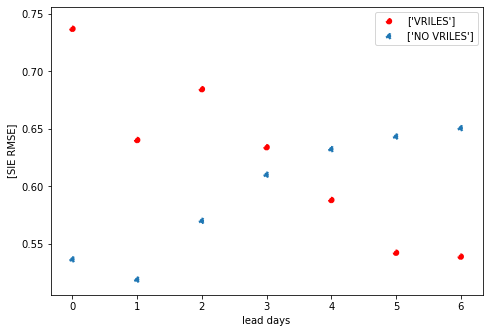

In [19]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1,1])
foo = SIE_errors.xs('panArctic').reset_index()
foo.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle='--',ax=ax1,color='r',label=['VRILES'])
foo2 = SIE_errors_NO.xs('panArctic').reset_index()
foo2.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle=':',ax=ax1,label=['NO VRILES'])

Replace <code>SIE anom RMSE</code> and <code>SIE anom MAE</code> in <code>SIE_errors</code> with corresponding entries from  <code>SIE_anom_errors</code> (and same for raw)

In [20]:
SIE_errors

SIE RMSE  SIE anom RMSE   SIE MAE  SIE anom MAE
region    lead days                                                 
Atlantic  0.0        0.152146       0.152666  0.118255      0.129271
          1.0        0.151704       0.139163  0.113103      0.118116
          2.0        0.202034       0.164179  0.162606      0.141254
          3.0        0.214997       0.179218  0.170190      0.159110
          4.0        0.218524       0.191991  0.171179      0.167202
...                       ...            ...       ...           ...
panArctic 2.0        0.684549       0.498367  0.599336      0.433923
          3.0        0.633967       0.535005  0.553509      0.472207
          4.0        0.587952       0.579020  0.503344      0.490062
          5.0        0.541996       0.573350  0.477144      0.481413
          6.0        0.538596       0.580325  0.469314      0.474856

[140 rows x 4 columns]

In [ ]:
SIE_errors[['SIE anom RMSE','SIE anom MAE']] = SIE_anom_errors[['SIE anom RMSE','SIE anom MAE']]
SIE_raw_err['SIE anom'] = SIE_anom_raw_err['SIE anom']

In [ ]:
lead_weeks

Save files!

In [ ]:
fdir = '../DATA/{model_name}/'.format(model_name=model_name)
fdir = fdir+'OBS_{obs_name}/'.format(obs_name=obs_name)
if lead_weeks == True:
    fdir = fdir+'lead_time_WEEKS/'
if not os.path.exists(fdir):
    os.makedirs(fdir)
fname_save_raw = fdir+'VRILE_vs_nonVRILE_RAW_err_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
fname_save_RMSE = fdir+'VRILE_vs_nonVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
SIE_raw_err.to_csv(fname_save_raw)
SIE_errors.to_csv(fname_save_RMSE)
print('files saved')

In [ ]:
fname_save_raw